## The Goal
- Each row in the dataset describes the characteristics of a house.
- Our goal is to predict the SalePrice, given these features.
- Our models are evaluated on the Root-Mean-Squared-Error (RMSE) between the log of the SalePrice predicted by our model, and the log of the actual SalePrice. Converting RMSE errors to a log scale ensures that errors in predicting expensive houses and cheap houses will affect our score equally.

In [59]:
#https://anaconda.org/conda-forge/mlxtend
#conda install -c conda-forge mlxtend

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, Ridge, LassoCV, RidgeCV ,ElasticNetCV, PassiveAggressiveRegressor, HuberRegressor, TheilSenRegressor

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor

from mlxtend.regressor import StackingCVRegressor

In [2]:
#Let's import our data

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [70]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [16]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [3]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

## Data Exploration

Let's plot how the features are correlated to each other, and to SalePrice

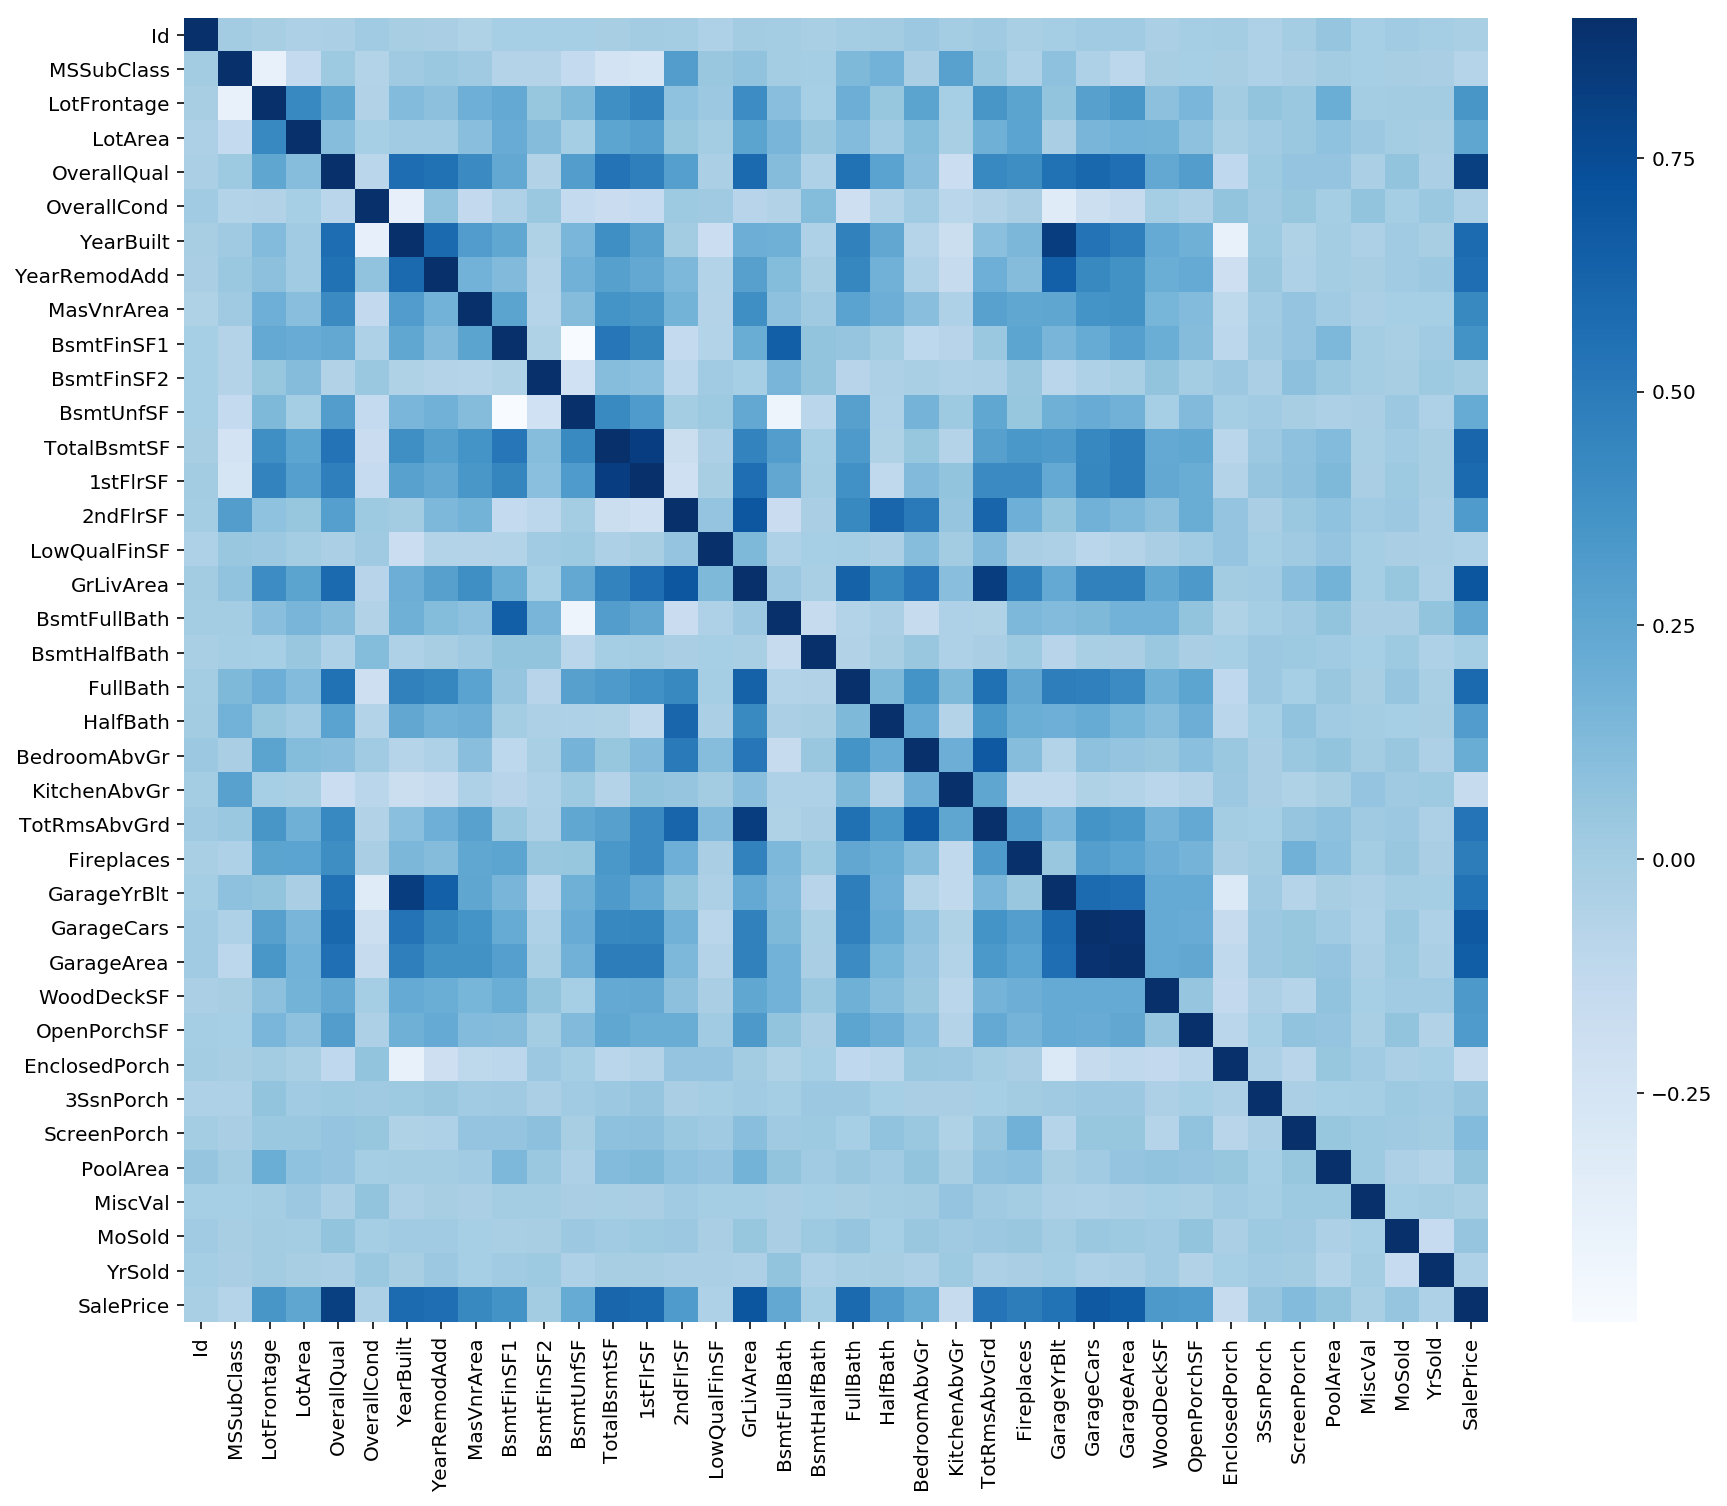

In [62]:
corr = train.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)

Let's plot how SalePrice relates to some of the features in the dataset

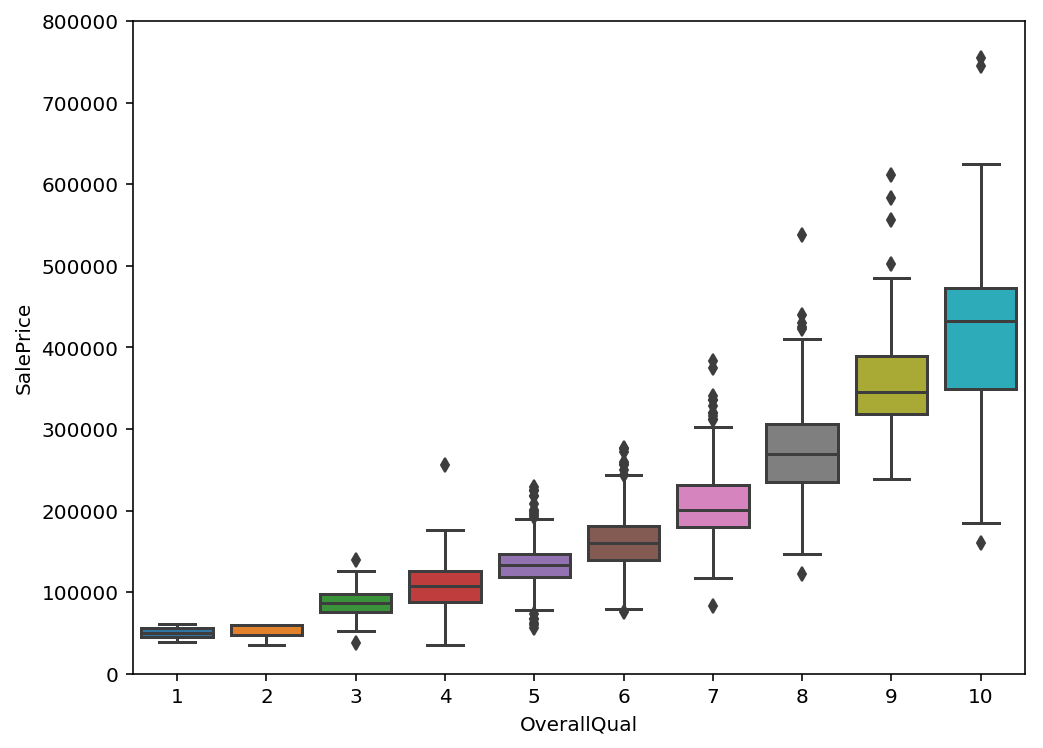

In [72]:
data = pd.concat([train['SalePrice'], train['OverallQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=train['OverallQual'], y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

That's seems quite correlated !

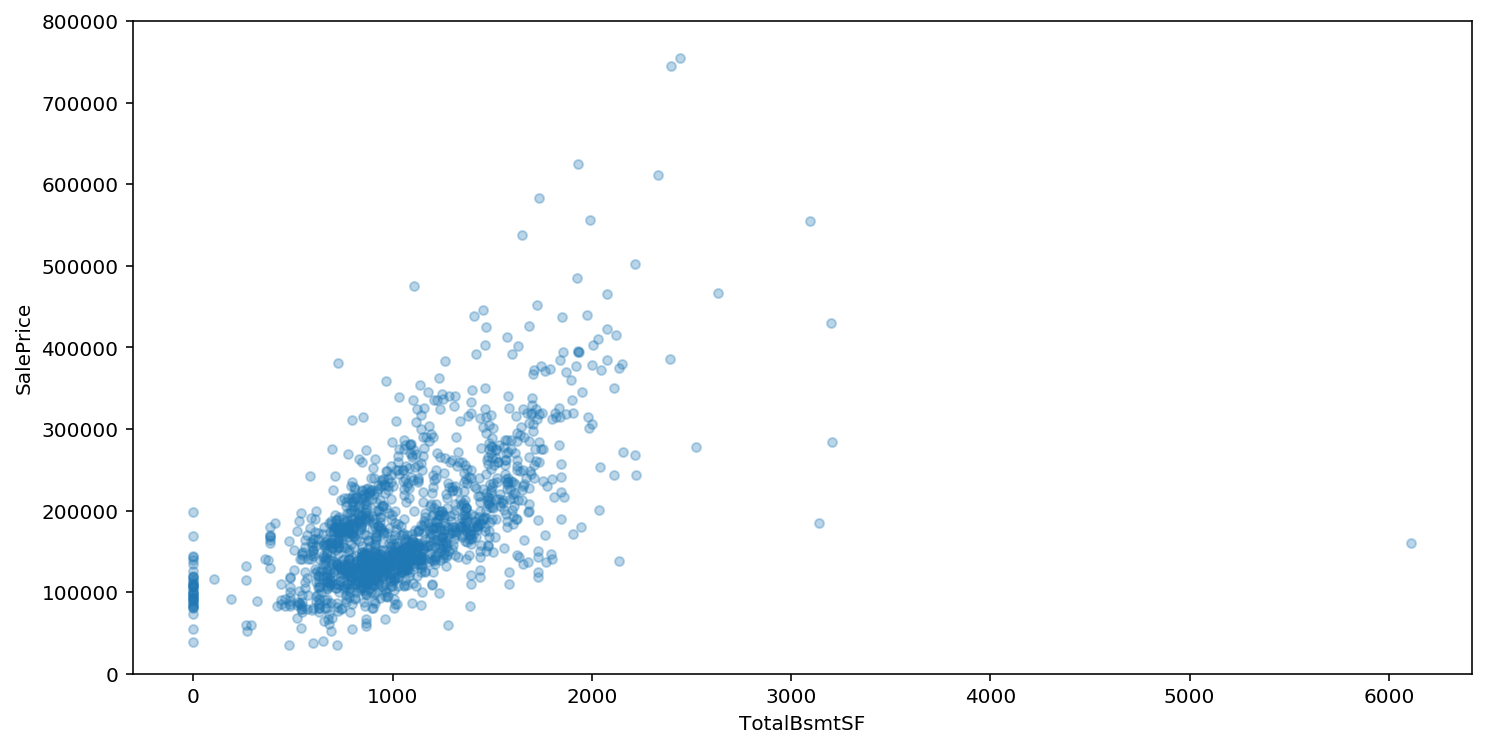

In [73]:
data = pd.concat([train['SalePrice'], train['TotalBsmtSF']], axis=1)
data.plot.scatter(x='TotalBsmtSF', y='SalePrice', alpha=0.3, ylim=(0,800000));

It seems to have a little tendance

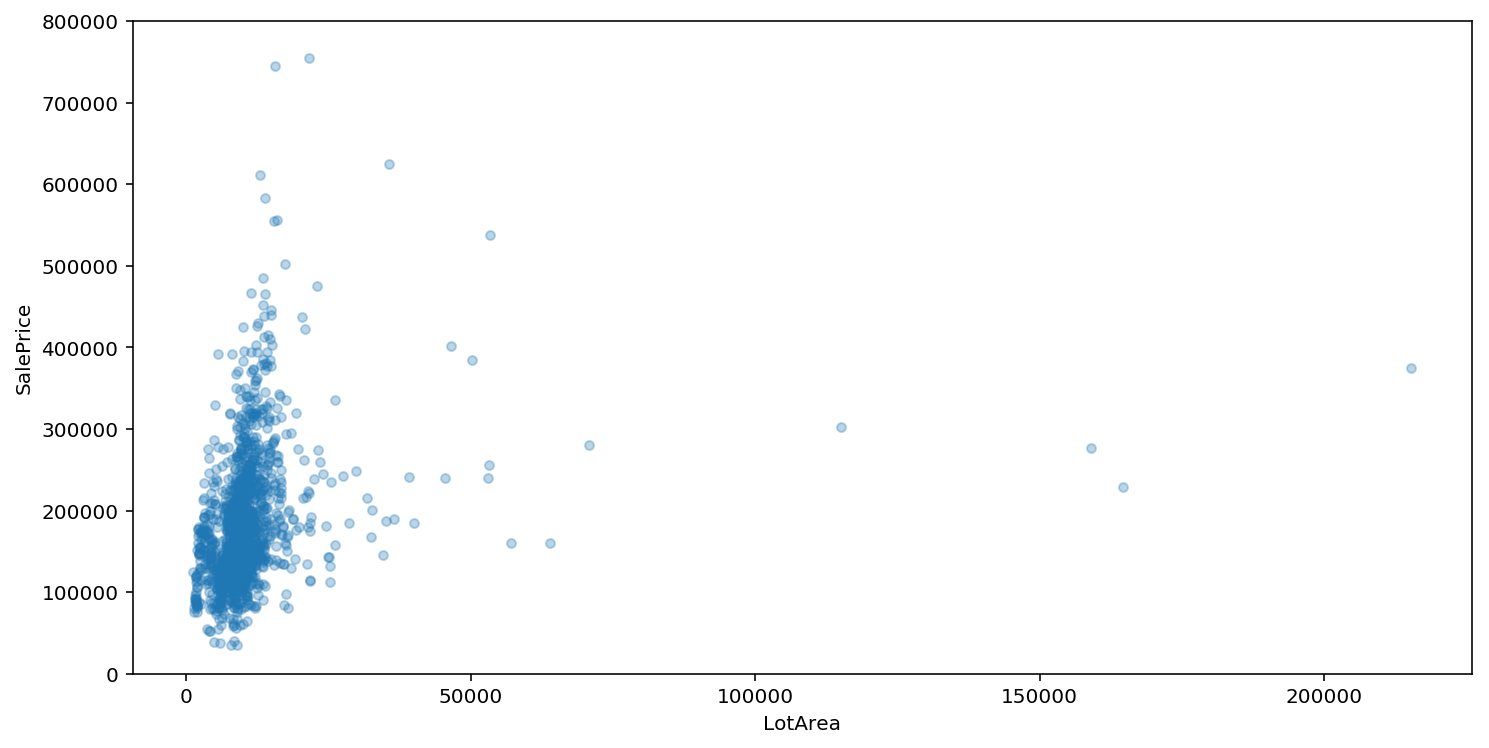

In [75]:
data = pd.concat([train['SalePrice'], train['LotArea']], axis=1)
data.plot.scatter(x='LotArea', y='SalePrice', alpha=0.3, ylim=(0,800000));

Here, these two variables doesn't seems related.

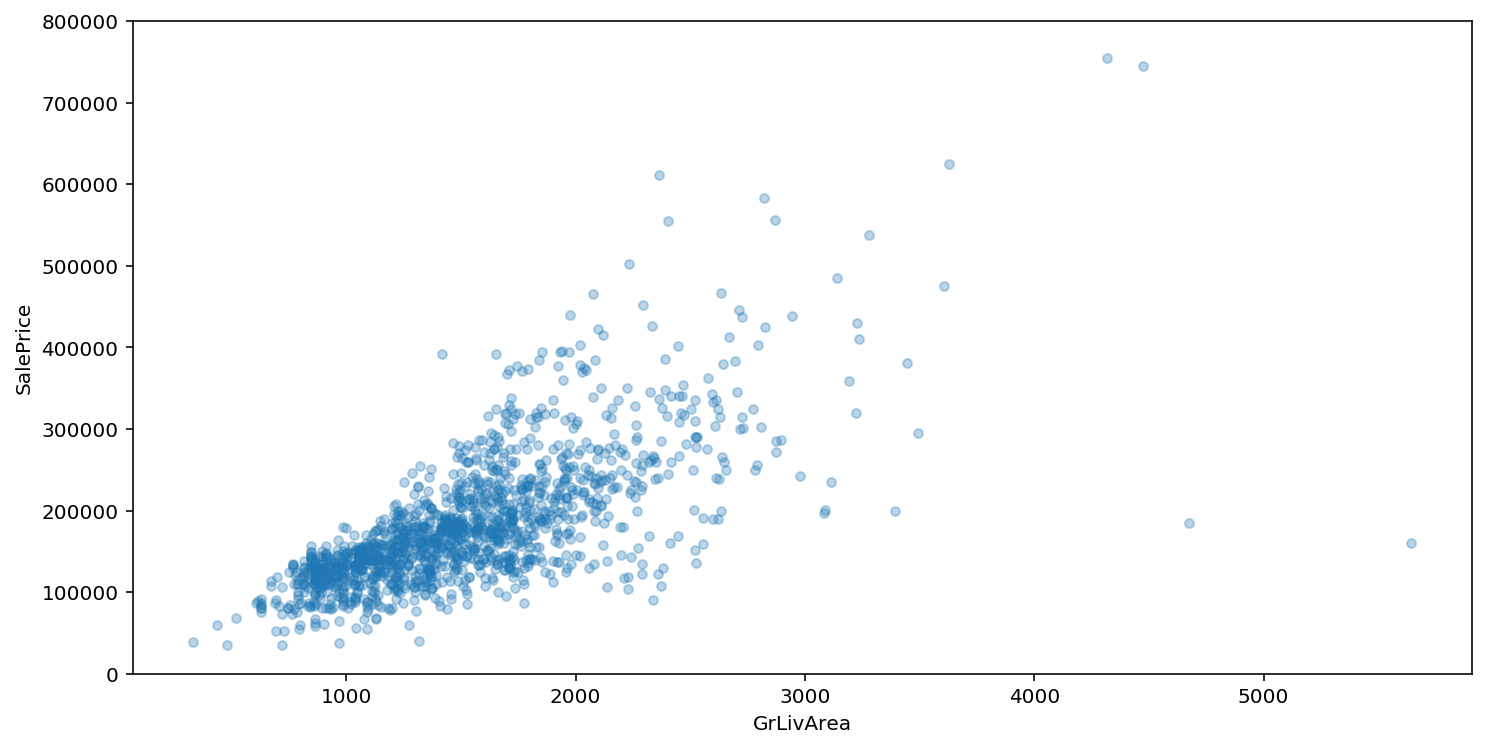

In [76]:
data = pd.concat([train['SalePrice'], train['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', alpha=0.3, ylim=(0,800000));

These two variable seems highly related !

### Data preprocessing: 
We're not going to do anything fancy here: 
 
- First I'll transform the skewed numeric features by taking log(feature + 1) - this will make the features more normal    
- Create Dummy variables for the categorical features    
- Replace the numeric missing values (NaN's) with the mean of their respective columns

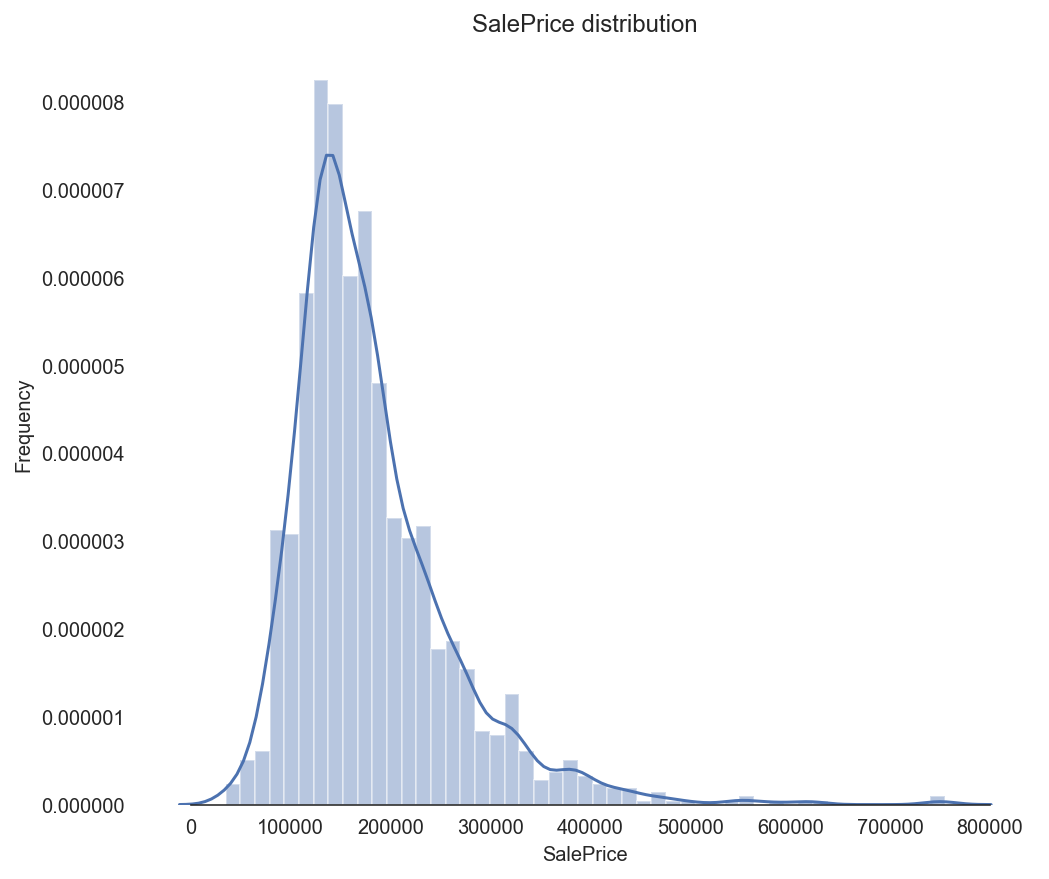

In [80]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train['SalePrice'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

The SalePrice is skewed to the right. This is a problem because most ML models don't do well with non-normally distributed data. We can apply a log(1+x) tranform to fix the skew.

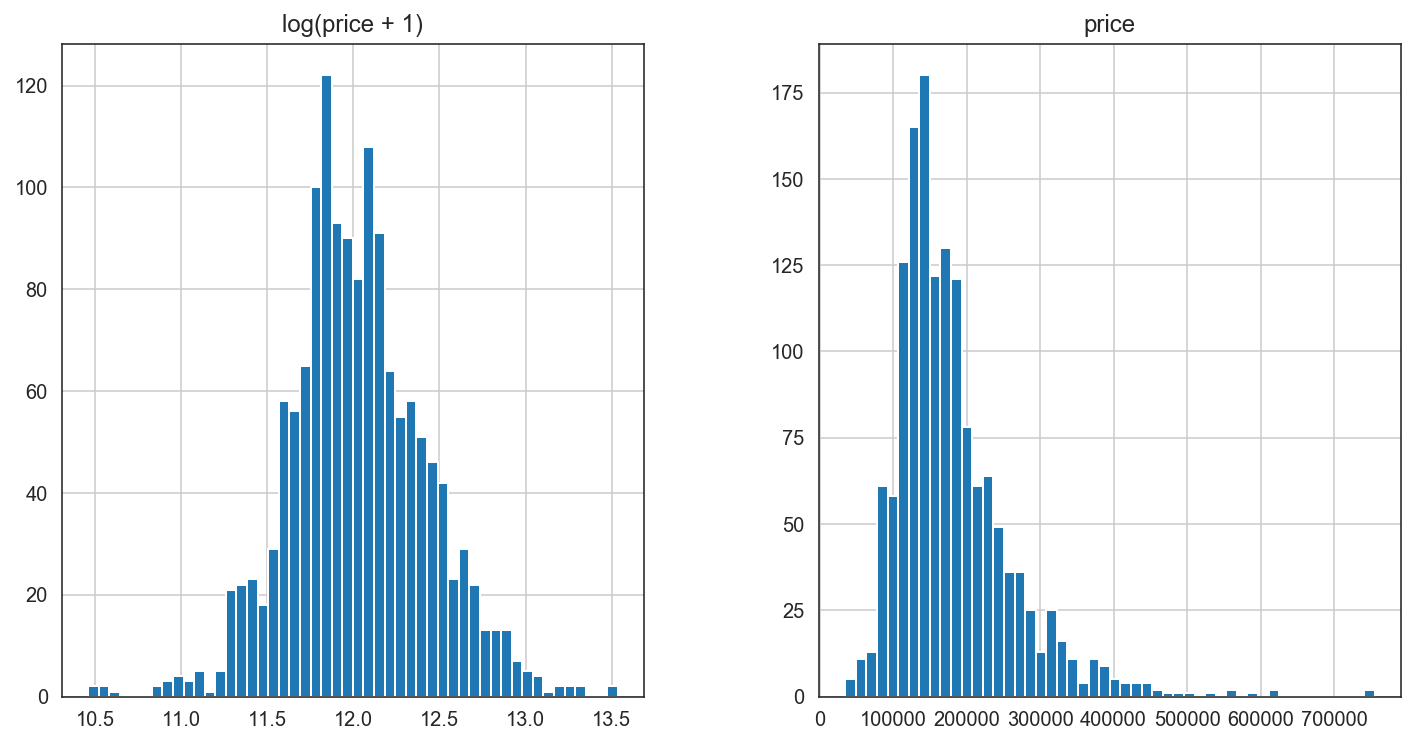

In [84]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist(bins = 50);

That's look better right ? The SalePrice is now normally distributed, great !

In [4]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

In [5]:
# Remove outliers
train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index, inplace=True)
train.drop(train[(train['GrLivArea']>4500) & (train['SalePrice']<300000)].index, inplace=True)
train.reset_index(drop=True, inplace=True)

### Fill missing values

Let's check the variable with the most missing values

In [9]:
all_data.isnull().sum().sort_values(ascending = False).head(30)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageQual       159
GarageYrBlt      159
GarageFinish     159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtFullBath       2
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
BsmtUnfSF          1
TotalBsmtSF        1
Exterior1st        1
SaleType           1
dtype: int64

We can now move through each of the features above and impute the missing values for each of them.

In [6]:
# Some of the non-numeric predictors are stored as numbers; convert them into strings 
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [7]:
def handle_missing(features):
    # the data description states that NA refers to typical ('Typ') values
    features['Functional'] = features['Functional'].fillna('Typ')
    # Replace the missing values in each of the columns below with their mode
    features['Electrical'] = features['Electrical'].fillna("SBrkr")
    features['KitchenQual'] = features['KitchenQual'].fillna("TA")
    features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
    features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
    features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
    features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    
    # the data description stats that NA refers to "No Pool"
    features["PoolQC"] = features["PoolQC"].fillna("None")
    # Replacing the missing values with 0, since no garage = no cars in garage
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        features[col] = features[col].fillna(0)
    # Replacing the missing values with None
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        features[col] = features[col].fillna('None')
    # NaN values for these categorical basement features, means there's no basement
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        features[col] = features[col].fillna('None')
        
    # Group the by neighborhoods, and fill in missing value by the median LotFrontage of the neighborhood
    features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # We have no particular intuition around how to fill in the rest of the categorical features
    # So we replace their missing values with None
    objects = []
    for i in features.columns:
        if features[i].dtype == object:
            objects.append(i)
    features.update(features[objects].fillna('None'))
        
    # And we do the same thing for numerical features, but this time with 0s
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numeric.append(i)
    features.update(features[numeric].fillna(0))    
    return features

all_data = handle_missing(all_data)

Let's make sure we handled all the missing values

In [15]:
all_data.isnull().sum().sort_values(ascending = False).head(5)

SaleCondition    0
Foundation       0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
dtype: int64

That's seems good !

## Fix skewed features

In [8]:
#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [28]:
skewed_feats

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

Here, I show all the skewed variables. I fixed that by applying the log transformation.

Let's encore our variables

In [12]:
all_data = pd.get_dummies(all_data).reset_index(drop=True)
all_data.shape

(2919, 380)

In [13]:
# Remove any duplicated column names
all_data = all_data.loc[:,~all_data.columns.duplicated()]

In [14]:
all_data.shape

(2919, 379)

### Create training and test set

In [37]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [60]:
print(X_train.shape)
print(X_test.shape)
print(y.shape)

(1458, 379)
(1459, 379)
(1458,)


### Train our models
Now we are going to visualize which model seems performs well with our function rmse_cv :

In [17]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [27]:
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring = "neg_mean_squared_error" , cv=5))
    return (rmse)

Let's see for all of the known model the rmse mean :

In [28]:
scores = {}

scores['xgboost'] = rmse_cv(XGBRegressor())

scores['LinearRegression'] = rmse_cv(LinearRegression())

scores['SGDRegressor'] = rmse_cv(SGDRegressor())

scores['Lasso'] = rmse_cv(Lasso())

scores['Ridge'] = rmse_cv(Ridge())

scores['PassiveAggressiveRegressor'] = rmse_cv(PassiveAggressiveRegressor())

scores['HuberRegressor'] = rmse_cv(HuberRegressor())

scores['TheilSenRegressor'] = rmse_cv(TheilSenRegressor())

scores['RandomForestRegressor'] = rmse_cv(RandomForestRegressor())

scores['ExtraTreesRegressor'] = rmse_cv(ExtraTreesRegressor())

scores['AdaBoostRegressor'] = rmse_cv(AdaBoostRegressor())

scores['GradientBoostingRegressor'] = rmse_cv(GradientBoostingRegressor())

scores['DecisionTreeRegressor'] = rmse_cv(DecisionTreeRegressor())

scores['ElasticNet'] = rmse_cv(ElasticNet())

scores['SVR'] = rmse_cv(SVR())


In [40]:
model_rmse = pd.DataFrame(scores).mean()
model_rmse = model_rmse.sort_values(ascending=True)
print('Model scores\n{}'.format(model_rmse))

Model scores
GradientBoostingRegressor     9.785892e-03
xgboost                       1.011946e-02
Ridge                         1.015227e-02
ExtraTreesRegressor           1.166494e-02
RandomForestRegressor         1.185616e-02
LinearRegression              1.255048e-02
AdaBoostRegressor             1.356070e-02
DecisionTreeRegressor         1.587984e-02
TheilSenRegressor             1.786735e-02
ElasticNet                    2.347676e-02
Lasso                         2.381834e-02
PassiveAggressiveRegressor    2.757508e-02
SVR                           3.220188e-02
HuberRegressor                3.687346e-02
SGDRegressor                  9.383025e+15
dtype: float64


So let's focus on GradientBoostingRegressor, XGBoost and Ridge !

For now let's create our Ridge model

#### Ridge

In [21]:
model_ridge = Ridge()

The main tuning parameter for the Ridge model is alpha - a regularization parameter that measures how flexible our model is. The higher the regularization the less prone our model will be to overfit. However it will also lose flexibility and might not capture all of the signal in the data. We need to find a compromise !

In [25]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]

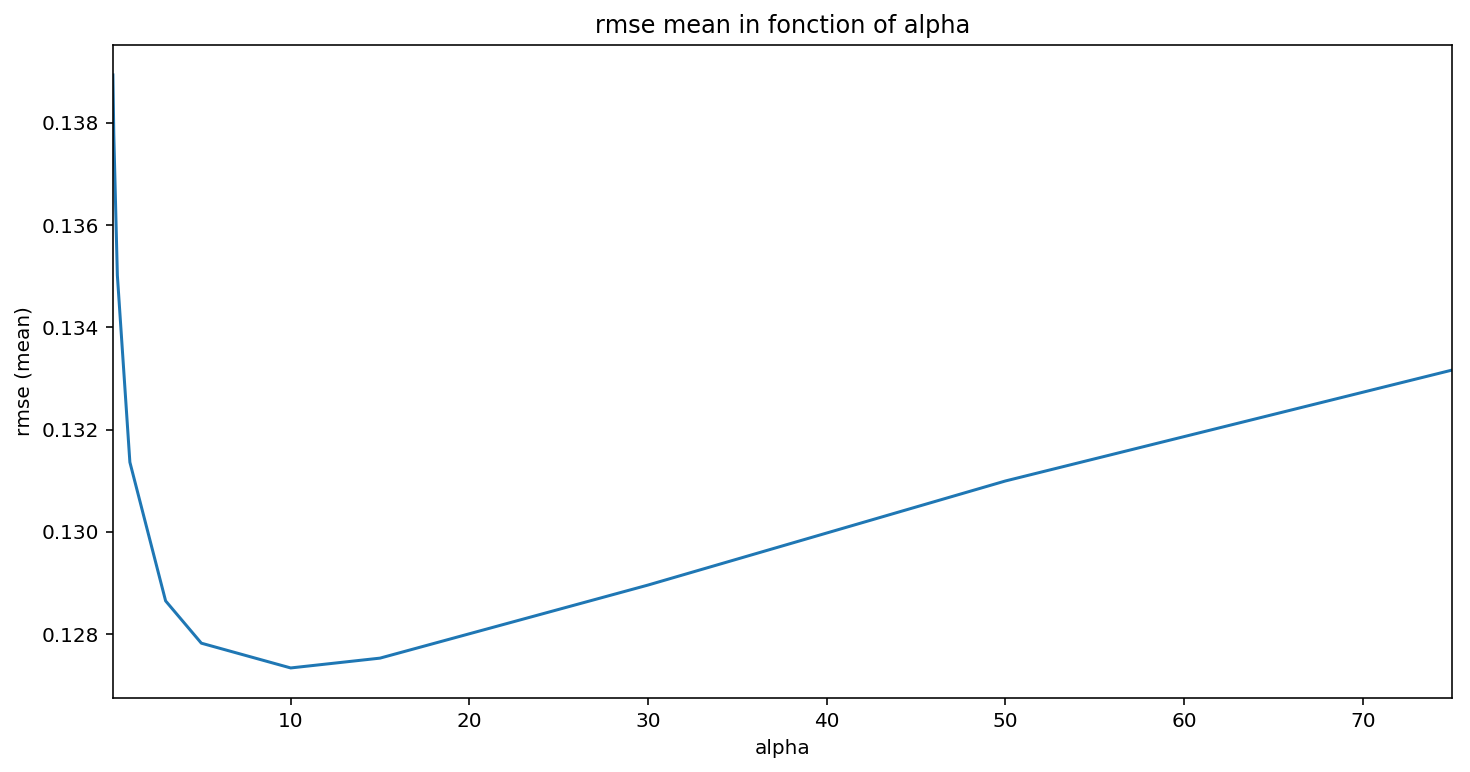

In [27]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "rmse mean in fonction of alpha")
plt.xlabel('alpha')
plt.ylabel('rmse (mean)');

Note the U-ish shaped curve above. When alpha is too large the regularization is too strong and the model cannot capture all the complexities in the data. If however we let the model be too flexible (alpha small) the model begins to overfit. A value of alpha = 10 is about right based on the plot above.

In [29]:
cv_ridge.min()

0.12733734668670743

So for the Ridge regression we get a rmse of about 0.127

In [41]:
model_ridge = Ridge(alpha = 10).fit(X_train, y)

 Another neat thing about the Ridge is that it does feature selection for you - setting coefficients of features it deems unimportant to zero. Let's take a look at the coefficients:

In [42]:
coef = pd.Series(model_ridge.coef_, index = X_train.columns)

In [43]:
print("Ridge picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Ridge picked 288 variables and eliminated the other 0 variables


We can also take a look directly at what the most important coefficients are:

In [70]:
imp_coef = pd.concat([coef.sort_values().head(10),
                    coef.sort_values().tail(10)])

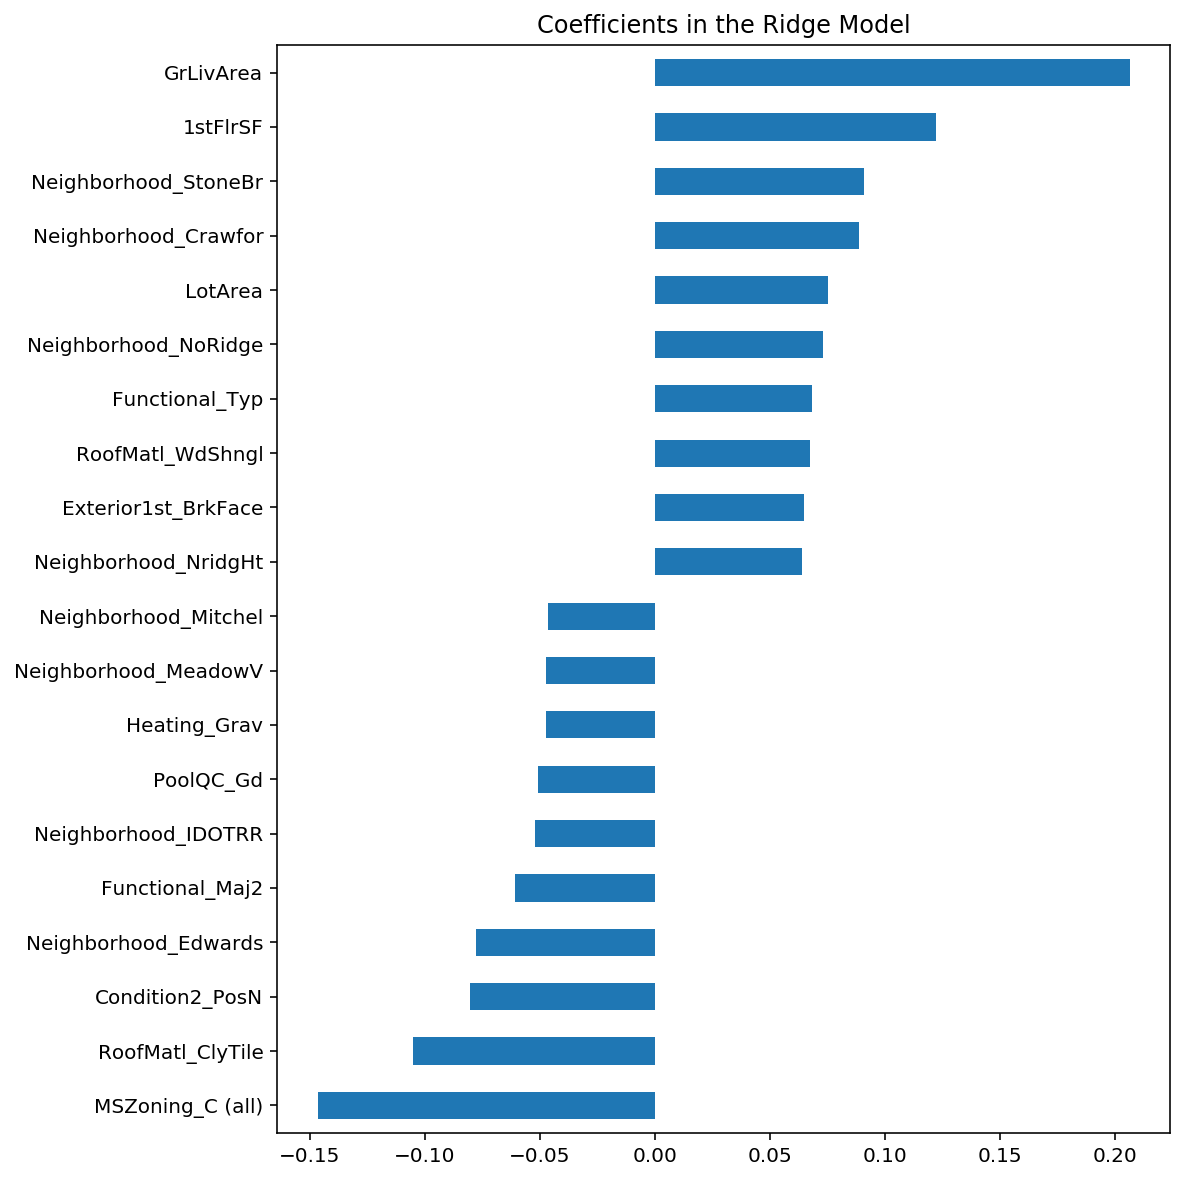

In [72]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model");

The most important positive feature is GrLivArea - the above ground area by area square feet. This definitely make sense. Then a few other location and quality features contributed positively. Some of the negative features make less sense and would be worth looking into more - it seems like they might come from unbalanced categorical variables.

Also note that unlike the feature importance you'd get from a random forest these are actual coefficients in your model - so you can say precisely why the predicted price is what it is. The only issue here is that we log_transformed both the target and the numeric features so the actual magnitudes are a bit hard to interpret.

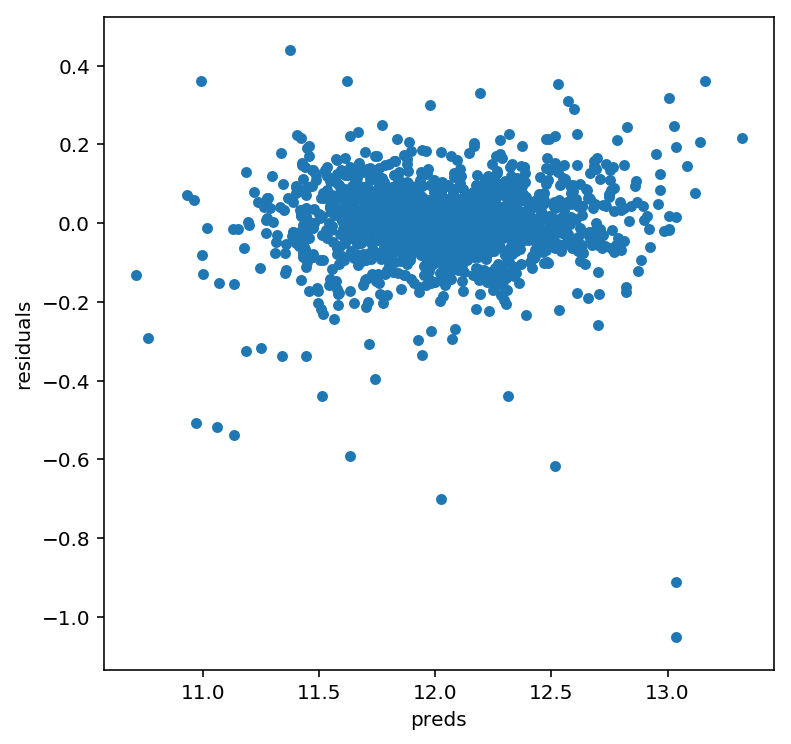

In [73]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_ridge.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter");

The residual plot looks pretty good.

#### XGBoost

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y, random_state = 3)

In [79]:
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_model.fit(X_tr, y_tr, early_stopping_rounds=5, 
             eval_set=[(X_val, y_val)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [80]:
my_model.get_params

<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)>

In [82]:
rmse_cv(XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)).mean()

C:\Users\Evan\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Evan\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Evan\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Evan\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Evan\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.12596044801636225

Amelioration des résultats avec notre hyperparameters tuning

#### GradientBoostingRegressor

In [26]:
from sklearn.model_selection import GridSearchCV


param_grid={'n_estimators':[100], 
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'max_depth':[4,6], 
            'min_samples_leaf':[3,5,9,17],
            'max_features':[1.0,0.3,0.1] }

GB = GradientBoostingRegressor()
clf = GridSearchCV(GB, param_grid, cv=5)
clf.fit(X_train, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [100], 'learning_rate': [0.1, 0.05, 0.02, 0.01], 'max_depth': [4, 6], 'min_samples_leaf': [3, 5, 9, 17], 'max_features': [1.0, 0.3, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [27]:
print(clf.best_params_)

{'learning_rate': 0.1, 'max_depth': 4, 'max_features': 0.3, 'min_samples_leaf': 3, 'n_estimators': 100}


In [28]:

rmse_cv(GradientBoostingRegressor
        (learning_rate= 0.1, max_depth= 4, max_features= 0.3, min_samples_leaf= 3, n_estimators= 100)).mean()

0.12558915071277088

GridSearchCV improve slightly our accuracy

Many times it makes sense to take a weighted average of uncorrelated results - this usually imporoves the score.

In [29]:
#GradientBoostingRegressor 

GB = GradientBoostingRegressor(learning_rate= 0.1, max_depth= 4, max_features= 0.3, min_samples_leaf= 3, n_estimators= 100)
GB.fit(X_train, y)
gb_preds = np.expm1(GB.predict(X_test))


# XGBRegressor

model_xgb = XGBRegressor(n_estimators=1000, learning_rate=0.05)
model_xgb.fit(X_tr, y_tr, early_stopping_rounds=5, 
             eval_set=[(X_val, y_val)], verbose=False)

xgb_preds = np.expm1(model_xgb.predict(X_test))

#RIDGE

model_ridge = Ridge(alpha = 10)
model_ridge.fit(X_train, y)

ridge_preds = np.expm1(model_ridge.predict(X_test))

C:\Users\Evan\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [30]:
preds = 0.4*gb_preds + 0.3*xgb_preds + 0.3* ridge_preds

In [31]:
solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
solution.to_csv("solution.csv", index = False)

We obtained with these models a 0.12144 submission RMSE, which is quite good, we are well place on the leaderboard but maybe we can do better ?



Let's try a method which I've seen in a Kernel on Kaggle, and see if I could increase my position on the leaderboard. If not, too bad, I could enhanced my skill at least !

### Setup our next models

In [50]:
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from mlxtend.regressor import StackingCVRegressor

# Setup cross validation folds
kf = KFold(n_splits=12, random_state=42, shuffle=True)

# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, svr, ridge, gbr, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [51]:
print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X_test), np.array(y))

stack_gen


In [52]:
print('lightgbm')
lgb_model_full_data = lightgbm.fit(X_test, y)

lightgbm


In [53]:
print('xgboost')
xgb_model_full_data = xgboost.fit(X_test, y)

xgboost


In [54]:
print('Svr')
svr_model_full_data = svr.fit(X_test, y)

Svr


In [55]:
print('Ridge')
ridge_model_full_data = ridge.fit(X_test, y)

Ridge


In [56]:
print('RandomForest')
rf_model_full_data = rf.fit(X, train_labels)

RandomForest


In [57]:
print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, train_labels)

GradientBoosting


In [ ]:
# Blend models in order to make the final predictions more robust to overfitting
def blended_predictions(X):
    return ((0.1 * np.expm1(ridge_model_full_data.predict(X))) + \
            (0.2 * np.expm1(svr_model_full_data.predict(X))) + \
            (0.1 * np.expm1(gbr_model_full_data.predict(X))) + \
            (0.1 * np.expm1(xgb_model_full_data.predict(X))) + \
            (0.1 * np.expm1(lgb_model_full_data.predict(X))) + \
            (0.05 * np.expm1(rf_model_full_data.predict(X))) + \
            (0.35 * np.expm1(stack_gen_model.predict(np.array(X)))))

solution2 = pd.DataFrame({"id":test.Id, "SalePrice":blended_predictions(X_test)})

solution2.to_csv("solution2.csv", index = False)

That's doesn't improve our submission RMSE, too bad. At least, we tried !